In [2]:
#  using local file
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("BGL Dataset Analysis from Local File System") \
    .getOrCreate()

# Define the local file path
local_file_path = "BGL.log"  # Replace with your actual local file path

# Load the dataset from the local filesystem
df = spark.read.text(local_file_path)


In [3]:
# Check if the log file is being read correctly
df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                              |
+---------------------------------------------------------------------------------------------------------------------------------------------------+
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.363779 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected|
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.527847 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected|
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.675872 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected|
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.823719 R02-M1-N0-C:J12-U11 RAS KERN

In [4]:
from pyspark.sql.functions import split, col, to_date, date_format, regexp_extract

# Assuming df is already loaded with the log data

# Split the log lines into columns
df = df.withColumn('alert_flag', split(df['value'], ' ')[0]) \
  .withColumn('timestamp', split(df['value'], ' ')[1]) \
  .withColumn('date', split(df['value'], ' ')[2]) \
  .withColumn('node', split(df['value'], ' ')[3]) \
  .withColumn('date_time', split(df['value'], ' ')[4]) \
  .withColumn('node_repeated', split(df['value'], ' ')[5]) \
  .withColumn('message_type', split(df['value'], ' ')[6]) \
  .withColumn('system_component', split(df['value'], ' ')[7]) \
  .withColumn('level', split(df['value'], ' ')[8]) \
  .withColumn('message_content', regexp_extract(df['value'], r'^(?:[^ ]+ ){9}(.*)$', 1)) \

# Convert date column to actual date type
df = df.withColumn('date', to_date(col('date'), 'yyyy.MM.dd'))

# Add a column for the day of the week
df = df.withColumn('day_of_week', date_format(col('date'), 'EEEE'))

# Extract the time part from the date_time column
df = df.withColumn('time', split(df['date_time'], '-')[3])

# Select and show the extracted columns
df.select('alert_flag', 'timestamp', 'date', 'day_of_week', 'node', 'date_time', 'time', 'node_repeated', 'message_type', 'system_component', 'level', 'message_content').show(10, truncate=False)





+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+----------------------------------------+
|alert_flag|timestamp |date      |day_of_week|node               |date_time                 |time           |node_repeated      |message_type|system_component|level|message_content                         |
+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+----------------------------------------+
|-         |1117838570|2005-06-03|Friday     |R02-M1-N0-C:J12-U11|2005-06-03-15.42.50.363779|15.42.50.363779|R02-M1-N0-C:J12-U11|RAS         |KERNEL          |INFO |instruction cache parity error corrected|
|-         |1117838570|2005-06-03|Friday     |R02-M1-N0-C:J12-U11|2005-06-03-15.42.50.527847|15.42.50.527847|R02-M1-N0-C:J12-U11|RAS         |KERNEL          |INFO |instruc

In [64]:
# # Filter the DataFrame for "APPUNAV" events
# appunav_df = df.filter(df['alert_flag'] == 'APPUNAV')

# # Group by the node and count the occurrences
# node_counts = appunav_df.groupBy('node').count()

# # Sort the result to find the node with the largest number of "APPUNAV" events
# sorted_node_counts = node_counts.orderBy('count', ascending=False)

# # Show the top result
# sorted_node_counts.show(10)


+-------------------+-----+
|               node|count|
+-------------------+-----+
|R15-M1-N0-I:J18-U11|    3|
|R37-M0-N0-I:J18-U11|    3|
|R36-M1-N4-I:J18-U01|    3|
|R21-M1-N8-I:J18-U01|    3|
|R13-M0-N4-I:J18-U01|    3|
|R05-M1-N0-I:J18-U11|    3|
|R36-M0-NC-I:J18-U11|    3|
|R32-M1-N4-I:J18-U11|    3|
|R13-M1-N0-I:J18-U11|    3|
|R24-M1-NC-I:J18-U01|    3|
+-------------------+-----+
only showing top 10 rows



In [4]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [5]:
# Q2 How many fatal log entries that occurred on a Tuesday or Thursday resulted from a ”machine check interrupt”?

In [5]:
# Filter logs with message_content containing "machine check interrupt"
filtered_df = df.filter(col('message_content').contains('machine check interrupt'))

# Count the number of filtered logs
total_count = filtered_df.count()

# Print the total number of logs
print(f"Total number of logs with message_content 'machine check interrupt': {total_count}")

# Show the top 10 logs
filtered_df.select('alert_flag', 'timestamp', 'date', 'day_of_week', 'node', 'date_time', 'time', 'node_repeated', 'message_type', 'system_component', 'level', 'message_content') \
           .show(10, truncate=False)


Total number of logs with message_content 'machine check interrupt': 295


+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+--------------------------------------------------------------------+
|alert_flag|timestamp |date      |day_of_week|node               |date_time                 |time           |node_repeated      |message_type|system_component|level|message_content                                                     |
+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+--------------------------------------------------------------------+
|KERNMC    |1117961699|2005-06-05|Sunday     |R11-M0-NB-C:J07-U11|2005-06-05-01.54.59.497454|01.54.59.497454|R11-M0-NB-C:J07-U11|RAS         |KERNEL          |FATAL|machine check interrupt                                             |
|KERNMC    |1118147576|2005-06-07|Tuesday    |R17-M0-N1-C:J0

In [7]:
#  Apply filter with day_of_week ="Tuesday or Thurday"

# Filter logs with message_content containing "machine check interrupt" and day_of_week as Tuesday or Thursday
filtered_df = df.filter(col('message_content').contains('machine check interrupt')) \
                 .filter((col('day_of_week') == 'Tuesday') | (col('day_of_week') == 'Thursday'))

# Count the number of filtered logs
num_logs = filtered_df.count()

# Show the number of logs
print(f"Number of logs: {num_logs}")

# Show top 10 logs that match the criteria
filtered_df.select('alert_flag', 'timestamp', 'date', 'day_of_week', 'node', 'date_time', 'time', 'node_repeated', 'message_type', 'system_component', 'level', 'message_content') \
           .show(10, truncate=False)



Number of logs: 83


+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+--------------------------------------------------------------------+
|alert_flag|timestamp |date      |day_of_week|node               |date_time                 |time           |node_repeated      |message_type|system_component|level|message_content                                                     |
+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+--------------------------------------------------------------------+
|KERNMC    |1118147576|2005-06-07|Tuesday    |R17-M0-N1-C:J03-U01|2005-06-07-05.32.56.626092|05.32.56.626092|R17-M0-N1-C:J03-U01|RAS         |KERNEL          |FATAL|machine check interrupt (bit=0x1d): L2 dcache unit data parity error|
|KERNMC    |1118352172|2005-06-09|Thursday   |R16-M0-N1-C:J1

In [8]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [9]:
# Q6 For each day of the week, what is the average number of seconds during which ”torus receiver z+ input pipe errors” were detected and corrected?


In [10]:
from pyspark.sql.functions import col, unix_timestamp, lag, when, avg, date_format
from pyspark.sql.window import Window

# Filter logs with 'torus receiver z+ input pipe error' in message_content
torus_receiver_logs = df.filter(col('message_content').contains('torus receiver z+ input pipe error'))

In [11]:
# Show the filtered logs with all columns
torus_receiver_logs.show(10)

# Show the count of filtered logs
print(f"Total count of logs with 'torus receiver z+ input pipe error': {torus_receiver_logs.count()}")

+--------------------+----------+----------+----------+-------------------+--------------------+-------------------+------------+----------------+-----+--------------------+-----------+---------------+
|               value|alert_flag| timestamp|      date|               node|           date_time|      node_repeated|message_type|system_component|level|     message_content|day_of_week|           time|
+--------------------+----------+----------+----------+-------------------+--------------------+-------------------+------------+----------------+-----+--------------------+-----------+---------------+
|- 1118070497 2005...|         -|1118070497|2005-06-06|R27-M0-N5-C:J11-U01|2005-06-06-08.08....|R27-M0-N5-C:J11-U01|         RAS|          KERNEL| INFO|1 torus receiver ...|     Monday|08.08.17.071414|
|- 1118070497 2005...|         -|1118070497|2005-06-06|R27-M0-ND-C:J14-U11|2005-06-06-08.08....|R27-M0-ND-C:J14-U11|         RAS|          KERNEL| INFO|1 torus receiver ...|     Monday|08.08.1

Total count of logs with 'torus receiver z+ input pipe error': 1914


In [12]:
# Filter logs with 'detected' and 'corrected' in message_content
detected_corrected_logs = torus_receiver_logs.filter((col('message_content').contains('detected and corrected')))
print(f"Total count of logs with 'detected and corrected': {detected_corrected_logs.count()}")

Total count of logs with 'detected and corrected': 1914


In [13]:
# Order by timestamp
detected_corrected_logs = detected_corrected_logs.orderBy('timestamp')

# Print the  first few rows
print("First few rows after filtering for detected and corrected:")
detected_corrected_logs.show(5)


First few rows after filtering for detected and corrected:


+--------------------+----------+----------+----------+-------------------+--------------------+-------------------+------------+----------------+-----+--------------------+-----------+---------------+
|               value|alert_flag| timestamp|      date|               node|           date_time|      node_repeated|message_type|system_component|level|     message_content|day_of_week|           time|
+--------------------+----------+----------+----------+-------------------+--------------------+-------------------+------------+----------------+-----+--------------------+-----------+---------------+
|- 1118070497 2005...|         -|1118070497|2005-06-06|R27-M0-N5-C:J11-U01|2005-06-06-08.08....|R27-M0-N5-C:J11-U01|         RAS|          KERNEL| INFO|1 torus receiver ...|     Monday|08.08.17.071414|
|- 1118070497 2005...|         -|1118070497|2005-06-06|R27-M0-ND-C:J14-U11|2005-06-06-08.08....|R27-M0-ND-C:J14-U11|         RAS|          KERNEL| INFO|1 torus receiver ...|     Monday|08.08.1

In [14]:
# Calculate duration between consecutive events
window_spec = Window.partitionBy('date').orderBy('timestamp')
detected_corrected_logs = detected_corrected_logs.withColumn('prev_timestamp', lag('timestamp', 1).over(window_spec))
detected_corrected_logs = detected_corrected_logs.withColumn('duration_seconds', when(col('prev_timestamp').isNull(), 0).otherwise((col('timestamp').cast('long') - col('prev_timestamp').cast('long'))))


In [15]:
# Print first few rows after calculating duration

print("First few rows after calculating duration:")
detected_corrected_logs.show(5)


First few rows after calculating duration:


+--------------------+----------+----------+----------+-------------------+--------------------+-------------------+------------+----------------+-----+--------------------+-----------+---------------+--------------+----------------+
|               value|alert_flag| timestamp|      date|               node|           date_time|      node_repeated|message_type|system_component|level|     message_content|day_of_week|           time|prev_timestamp|duration_seconds|
+--------------------+----------+----------+----------+-------------------+--------------------+-------------------+------------+----------------+-----+--------------------+-----------+---------------+--------------+----------------+
|- 1118070497 2005...|         -|1118070497|2005-06-06|R27-M0-N5-C:J11-U01|2005-06-06-08.08....|R27-M0-N5-C:J11-U01|         RAS|          KERNEL| INFO|1 torus receiver ...|     Monday|08.08.17.071414|          NULL|               0|
|- 1118070497 2005...|         -|1118070497|2005-06-06|R27-M0-ND

In [16]:
# Aggregate by day of week and calculate average duration in seconds
avg_duration_per_day = detected_corrected_logs.groupBy('day_of_week').agg(avg('duration_seconds').alias('avg_duration_seconds'))

# Print the average duration per day
print("Average duration per day:")
avg_duration_per_day.show()

Average duration per day:


+-----------+--------------------+
|day_of_week|avg_duration_seconds|
+-----------+--------------------+
|  Wednesday|  1456.3508771929824|
|    Tuesday|   4795.864583333333|
|     Friday|   3935.622009569378|
|   Thursday|   2763.583870967742|
|   Saturday|   6913.522388059701|
|     Monday|  3467.0576923076924|
|     Sunday|  5998.2316384180795|
+-----------+--------------------+



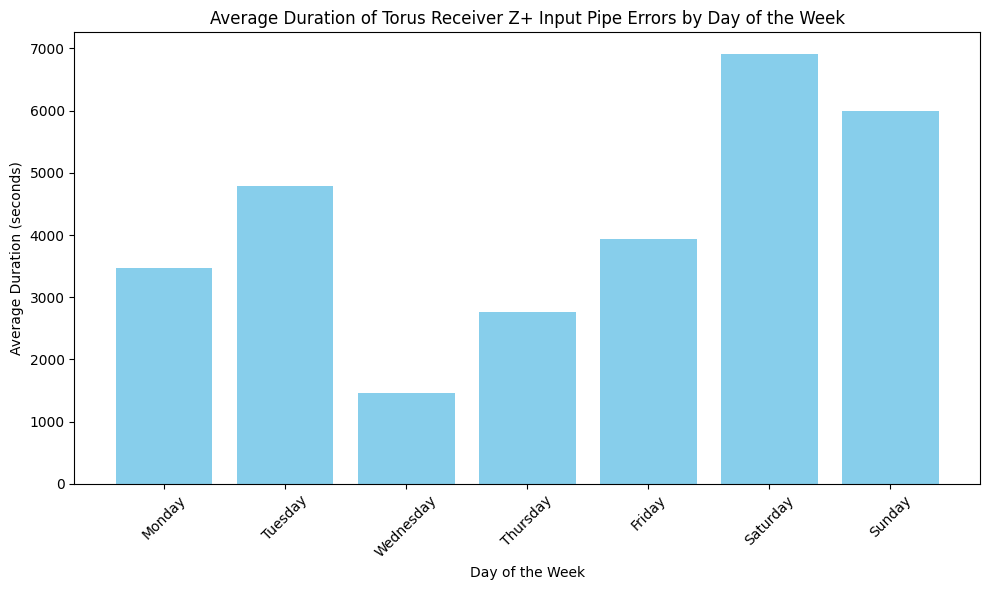

In [17]:
# plot the graph
import pandas as pd
import matplotlib.pyplot as plt

# Convert the result to a pandas dataframe for plotting
avg_duration_per_day_pd = avg_duration_per_day.toPandas()

# Sort the dataframe by day_of_week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_duration_per_day_pd['day_of_week'] = pd.Categorical(avg_duration_per_day_pd['day_of_week'], categories=day_order, ordered=True)
avg_duration_per_day_pd = avg_duration_per_day_pd.sort_values('day_of_week')

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(avg_duration_per_day_pd['day_of_week'], avg_duration_per_day_pd['avg_duration_seconds'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Duration (seconds)')
plt.title('Average Duration of Torus Receiver Z+ Input Pipe Errors by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Stop the Spark session
spark.stop()

In [19]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [20]:
#  using SPARK RDD

In [21]:
from pyspark.sql import SparkSession
from datetime import datetime

# Create a Spark session
spark = SparkSession.builder \
    .appName("BGL Log Analysis with RDD") \
    .getOrCreate()

# Access the SparkContext from the Spark session
sc = spark.sparkContext

# Define the local file path
local_file_path = "BGL.log"  # Replace with your actual local file path

# Load the dataset into an RDD
rdd = sc.textFile(local_file_path)

# Function to parse each log entry
def parse_log_entry(log_entry):
    parts = log_entry.split(' ')
    if len(parts) >= 9:
        alert_flag = parts[0]
        timestamp = parts[1]
        date = parts[2]
        node = parts[3]
        date_time = parts[4]
        node_repeated = parts[5]
        message_type = parts[6]
        system_component = parts[7]
        level = parts[8]
        message_content = ' '.join(parts[9:])
        # Convert date to actual date type and extract day of the week
        date_obj = datetime.strptime(date, '%Y.%m.%d')
        day_of_week = date_obj.strftime('%A')
        # Extract the time part from the date_time column
        time = date_time.split('-')[3]
        return (alert_flag, timestamp, date, day_of_week, node, date_time, time, node_repeated, message_type, system_component, level, message_content)
    else:
        return None

# Parse the log entries and filter out any invalid entries
parsed_rdd = rdd.map(parse_log_entry).filter(lambda x: x is not None)


# If you want to convert the RDD to a DataFrame and show it using DataFrame operations
columns = ['alert_flag', 'timestamp', 'date', 'day_of_week', 'node', 'date_time', 'time', 'node_repeated', 'message_type', 'system_component', 'level', 'message_content']
df = parsed_rdd.toDF(columns)
df.show(10, truncate=False)




+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+----------------------------------------+
|alert_flag|timestamp |date      |day_of_week|node               |date_time                 |time           |node_repeated      |message_type|system_component|level|message_content                         |
+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+----------------------------------------+
|-         |1117838570|2005.06.03|Friday     |R02-M1-N0-C:J12-U11|2005-06-03-15.42.50.363779|15.42.50.363779|R02-M1-N0-C:J12-U11|RAS         |KERNEL          |INFO |instruction cache parity error corrected|
|-         |1117838570|2005.06.03|Friday     |R02-M1-N0-C:J12-U11|2005-06-03-15.42.50.527847|15.42.50.527847|R02-M1-N0-C:J12-U11|RAS         |KERNEL          |INFO |instruc

24/07/28 22:32:51 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker


In [22]:
# Q12 What are the top 6 most frequently occurring hours in the log?

In [66]:
from pyspark.sql import SparkSession
from datetime import datetime

# Create a Spark session
spark = SparkSession.builder \
    .appName("BGL Log Analysis with RDD") \
    .getOrCreate()

# Access the SparkContext from the Spark session
sc = spark.sparkContext

# Define the local file path
local_file_path = "BGL.log"  # Replace with your actual local file path

# Load the dataset into an RDD
rdd = sc.textFile(local_file_path)

# Function to parse each log entry
def parse_log_entry_2(log_entry):
    parts = log_entry.split(' ')
    if len(parts) >= 9:
        date_time = parts[4]
        time = date_time.split('-')[3]  # Extract time part
        hour = time.split('.')[0]  # Extract hour
        return (hour, 1)
    else:
        return None

# Parse the log entries and filter out any invalid entries
parsed_rdd = rdd.map(parse_log_entry_2).filter(lambda x: x is not None)



# Count the occurrences of each hour
hour_counts = parsed_rdd.reduceByKey(lambda a, b: a + b)

# Sort the hours by count in descending order and take the top 6
top_6_hours = hour_counts.sortBy(lambda x: x[1], ascending=False).take(6)

# Print the top 6 most frequently occurring hours
print("Top 6 most frequently occurring hours:")
for hour, count in top_6_hours:
    print(f"Hour: {hour}, Count: {count}")




24/07/28 23:42:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Top 6 most frequently occurring hours:
Hour: 11, Count: 388648
Hour: 10, Count: 379141
Hour: 12, Count: 354389
Hour: 08, Count: 315017
Hour: 09, Count: 308801
Hour: 17, Count: 299297


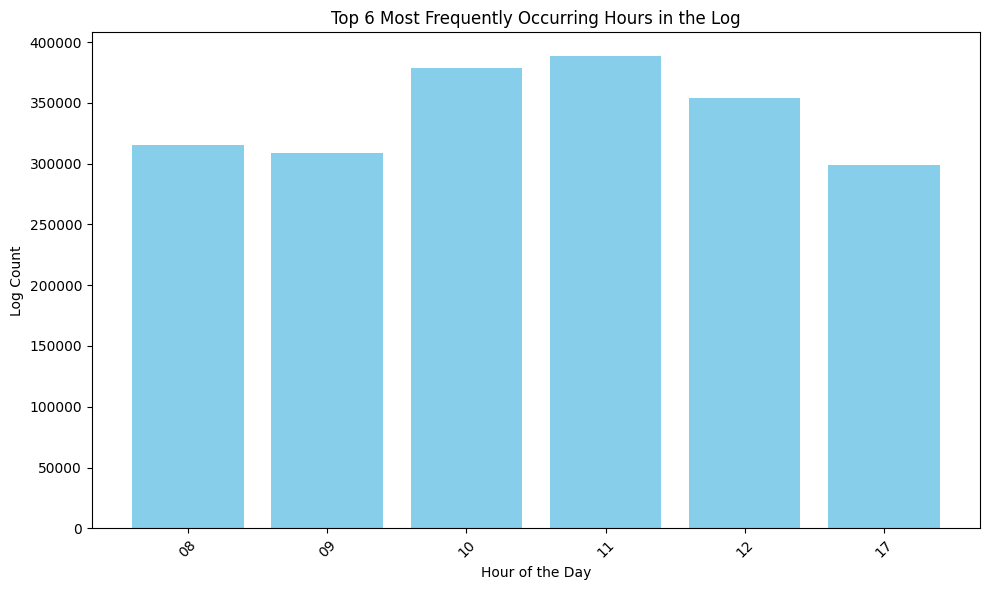

In [24]:
#  plotting the graph
import pandas as pd
import matplotlib.pyplot as plt

# Convert the top 6 hours data to a Pandas DataFrame
top_6_hours_df = pd.DataFrame(top_6_hours, columns=['Hour', 'Count'])

# Sort the DataFrame by hour for plotting
top_6_hours_df = top_6_hours_df.sort_values(by='Hour')

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_6_hours_df['Hour'], top_6_hours_df['Count'], color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Log Count')
plt.title('Top 6 Most Frequently Occurring Hours in the Log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
# Q16 Which node generated the largest number of APPUNAV events?

In [67]:
# Filter the DataFrame for "APPUNAV" events
appunav_df = df.filter(df['alert_flag'] == 'APPUNAV')

# Group by the node and count the occurrences
node_counts = appunav_df.groupBy('node').count()

# Sort the result to find the nodes with the largest number of "APPUNAV" events
sorted_node_counts = node_counts.orderBy('count', ascending=False)

# Show the top 10 results
sorted_node_counts.show(10)

+-------------------+-----+
|               node|count|
+-------------------+-----+
|R15-M1-N0-I:J18-U11|    3|
|R37-M0-N0-I:J18-U11|    3|
|R36-M1-N4-I:J18-U01|    3|
|R21-M1-N8-I:J18-U01|    3|
|R13-M0-N4-I:J18-U01|    3|
|R05-M1-N0-I:J18-U11|    3|
|R36-M0-NC-I:J18-U11|    3|
|R32-M1-N4-I:J18-U11|    3|
|R13-M1-N0-I:J18-U11|    3|
|R24-M1-NC-I:J18-U01|    3|
+-------------------+-----+
only showing top 10 rows



In [68]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [26]:
# Q17 On which date and time was the latest KERNEL INFO message where an instruction cache parity error was corrected?


In [27]:
# Function to parse each log entry and filter relevant entries
def parse_and_filter_log_entry(log_entry):
    parts = log_entry.split(' ')
    if len(parts) >= 9:
        timestamp = parts[1]
        date = parts[2]
        node = parts[3]
        date_time = parts[4]
        system_component = parts[7]
        level = parts[8]
        message_content = ' '.join(parts[9:])
        if system_component == 'KERNEL' and level == 'INFO' and 'instruction cache parity error corrected' in message_content:
            return (timestamp, date, date_time, message_content)
    return None

# Parse and filter the log entries
filtered_rdd = rdd.map(parse_and_filter_log_entry).filter(lambda x: x is not None)

# Convert the RDD to a DataFrame to use the date and time functions
from pyspark.sql import Row

rows = filtered_rdd.map(lambda x: Row(timestamp=x[0], date=x[1], date_time=x[2], message_content=x[3]))
df = spark.createDataFrame(rows)

# Convert the timestamp to a datetime format and sort by the timestamp to get the latest entry
df = df.withColumn("timestamp", df["timestamp"].cast("long"))

# Get the latest entry
latest_entry = df.orderBy(df.timestamp.desc()).first()

# Print the result
if latest_entry:
    latest_date = latest_entry.date
    latest_time = latest_entry.date_time
    print(f"Latest KERNEL INFO message where an instruction cache parity error was corrected was on date: {latest_date} at time: {latest_time}")
else:
    print("No relevant KERNEL INFO messages found.")

# Stop the Spark session
spark.stop()

Latest KERNEL INFO message where an instruction cache parity error was corrected was on date: 2006.01.04 at time: 2006-01-04-04.46.38.802083


In [28]:
# ADDITIONAL ANALYSIS

In [29]:
# using spark and hdfs

from pyspark.sql import SparkSession

# Define the HDFS Namenode IP and port
namenode_ip = "172.20.10.5"  # Replace with your actual Namenode IP
namenode_port = "9000"
hdfs_url = f"hdfs://{namenode_ip}:{namenode_port}"

# Create a Spark session with Hadoop configurations
spark = SparkSession.builder \
    .appName("BGL Dataset Analysis from HDFS") \
    .config("spark.hadoop.fs.defaultFS", hdfs_url) \
    .config("spark.hadoop.fs.hdfs.impl", "org.apache.hadoop.hdfs.DistributedFileSystem") \
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .getOrCreate()

# Load the dataset from HDFS
df = spark.read.text(f"{hdfs_url}/hduser/nipunserver/logs/BGL.log")

In [30]:
# Check if the log file is being read correctly
df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                              |
+---------------------------------------------------------------------------------------------------------------------------------------------------+
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.363779 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected|
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.527847 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected|
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.675872 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected|
|- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.823719 R02-M1-N0-C:J12-U11 RAS KERN

In [31]:
from pyspark.sql.functions import split, col, to_date, date_format, regexp_extract

# Assuming df is already loaded with the log data

# Split the log lines into columns
df = df.withColumn('alert_flag', split(df['value'], ' ')[0]) \
  .withColumn('timestamp', split(df['value'], ' ')[1]) \
  .withColumn('date', split(df['value'], ' ')[2]) \
  .withColumn('node', split(df['value'], ' ')[3]) \
  .withColumn('date_time', split(df['value'], ' ')[4]) \
  .withColumn('node_repeated', split(df['value'], ' ')[5]) \
  .withColumn('message_type', split(df['value'], ' ')[6]) \
  .withColumn('system_component', split(df['value'], ' ')[7]) \
  .withColumn('level', split(df['value'], ' ')[8]) \
  .withColumn('message_content', regexp_extract(df['value'], r'^(?:[^ ]+ ){9}(.*)$', 1)) \

# Convert date column to actual date type
df = df.withColumn('date', to_date(col('date'), 'yyyy.MM.dd'))

# Add a column for the day of the week
df = df.withColumn('day_of_week', date_format(col('date'), 'EEEE'))

# Extract the time part from the date_time column
df = df.withColumn('time', split(df['date_time'], '-')[3])

# Select and show the extracted columns
df.select('alert_flag', 'timestamp', 'date', 'day_of_week', 'node', 'date_time', 'time', 'node_repeated', 'message_type', 'system_component', 'level', 'message_content').show(10, truncate=False)





+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+----------------------------------------+
|alert_flag|timestamp |date      |day_of_week|node               |date_time                 |time           |node_repeated      |message_type|system_component|level|message_content                         |
+----------+----------+----------+-----------+-------------------+--------------------------+---------------+-------------------+------------+----------------+-----+----------------------------------------+
|-         |1117838570|2005-06-03|Friday     |R02-M1-N0-C:J12-U11|2005-06-03-15.42.50.363779|15.42.50.363779|R02-M1-N0-C:J12-U11|RAS         |KERNEL          |INFO |instruction cache parity error corrected|
|-         |1117838570|2005-06-03|Friday     |R02-M1-N0-C:J12-U11|2005-06-03-15.42.50.527847|15.42.50.527847|R02-M1-N0-C:J12-U11|RAS         |KERNEL          |INFO |instruc

In [32]:
# I. Error Analysis

In [33]:
from pyspark.sql.functions import count

# Count occurrences of each error message
error_counts = df.filter(col('level') == 'FATAL').groupBy('message_content').agg(count('*').alias('count')).orderBy('count', ascending=False)

# Show the top 10 errors
error_counts.show(10,truncate=False)



+------------------------------------------------------------------------------------------------------------------------------------------+------+
|message_content                                                                                                                           |count |
+------------------------------------------------------------------------------------------------------------------------------------------+------+
|data TLB error interrupt                                                                                                                  |152734|
|data storage interrupt                                                                                                                    |63491 |
|instruction address: 0x00004ed8                                                                                                           |47104 |
|ciod: Error loading /bgl/apps/scaletest/performance/MINIBEN/mb_243_0810/allreduce.rts: invalid or missing progr

In [34]:
# II. Node-Specific Analysis

In [35]:
# Filter data for a specific node
node_specific_df = df.filter(col('node') == 'R02-M1-N0-C:J12-U11')

# Count occurrences of each message type for the node
node_message_counts = node_specific_df.groupBy('message_type').agg(count('*').alias('count')).orderBy('count', ascending=False)

# Show the results
node_message_counts.show()


+------------+-----+
|message_type|count|
+------------+-----+
|         RAS|64651|
+------------+-----+



In [36]:
#  III. TREND ANALYSIS

In [37]:
from pyspark.sql.functions import window, avg

# Aggregate data by day
daily_events = df.groupBy(window(col('date'), '1 day')).agg(count('*').alias('count')).orderBy('window')

# Calculate moving average to identify trends
from pyspark.sql.window import Window
moving_avg = daily_events.withColumn('moving_avg', avg('count').over(Window.orderBy('window').rowsBetween(-7, 0)))

# Show the results
moving_avg.show()


24/07/28 22:33:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 2

+--------------------+------+------------------+
|              window| count|        moving_avg|
+--------------------+------+------------------+
|{2005-06-03 00:00...| 14733|           14733.0|
|{2005-06-04 00:00...|  2733|            8733.0|
|{2005-06-05 00:00...|101380|39615.333333333336|
|{2005-06-06 00:00...| 39462|           39577.0|
|{2005-06-07 00:00...| 31924|           38046.4|
|{2005-06-08 00:00...| 10676|33484.666666666664|
|{2005-06-09 00:00...| 20283|31598.714285714286|
|{2005-06-10 00:00...|  1462|         27831.625|
|{2005-06-11 00:00...|152669|         45073.625|
|{2005-06-12 00:00...|  3420|           45159.5|
|{2005-06-13 00:00...| 37062|          37119.75|
|{2005-06-14 00:00...|381561|         79882.125|
|{2005-06-15 00:00...| 14972|         77763.125|
|{2005-06-16 00:00...| 24590|         79502.375|
|{2005-06-17 00:00...|  4073|         77476.125|
|{2005-06-18 00:00...|  5301|           77956.0|
|{2005-06-19 00:00...|  3359|          59292.25|
|{2005-06-20 00:00..

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect the data from the Spark DataFrame
moving_avg_pd = moving_avg.toPandas()

# Convert the window start time to a datetime object for plotting
moving_avg_pd['window_start'] = pd.to_datetime(moving_avg_pd['window'].apply(lambda x: x['start']))

# Sort the DataFrame by window start time
moving_avg_pd = moving_avg_pd.sort_values(by='window_start')



24/07/28 22:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/28 2

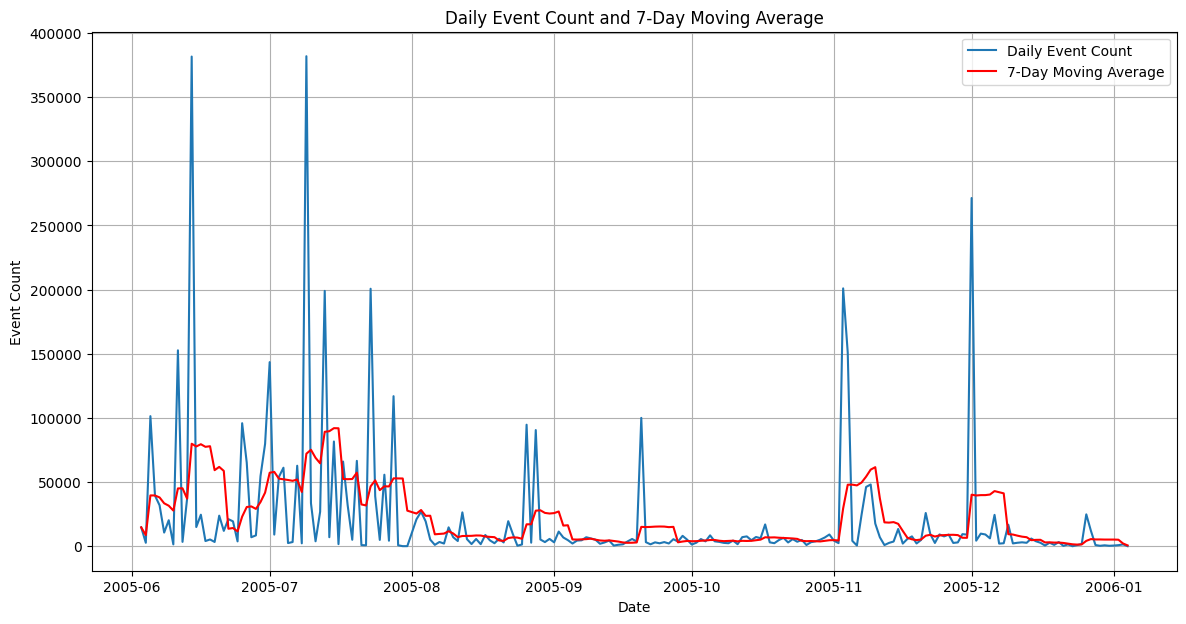

In [39]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(moving_avg_pd['window_start'], moving_avg_pd['count'], label='Daily Event Count')
plt.plot(moving_avg_pd['window_start'], moving_avg_pd['moving_avg'], label='7-Day Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.title('Daily Event Count and 7-Day Moving Average')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Stop the Spark session
spark.stop()